In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from qiime2 import Artifact, Visualization
from scipy.stats import spearmanr, kruskal, pearsonr

%matplotlib inline

In [2]:
cd ../200608_Elsayed_Lowry-1101/reanalysis-2/

/Users/johnsterrett/Research-Projects/Boulder/Chemobrain/200608_Elsayed_Lowry-1101/reanalysis-2


In [3]:
cp ../insertion-tree.qza insertion-tree.qza

In [4]:
ls

ANCOM-L2-chemo.qzv                  lefse_cesd_in.tsv
ANCOM-L6-chemo.qzv                  lefse_cesd_out.lefse_internal_res
CESD-LEfSe.pdf                      lefse_cesd_plotdata.csv
Chemo-LEfSe.pdf                     lefse_chemo_in.tsv
Figures/                            lefse_chemo_out.lefse_internal_res
L2-nobloom-pseudo-table.qza         lefse_chemo_plotdata.csv
L2-nobloom-table.qza                lefse_fact_in.tsv
L6-nobloom-pseudo-table.qza         lefse_fact_out.lefse_internal_res
L6-nobloom-table.qza                nobloom_metadata.tsv
core-diversity-results/             nobloom_table.qza
diversity-stats-results/            nobloom_table.qzv
expr-group-metadata.tsv             samp-filt-seq-table.qza
filt-seq-taxa-barplot.qzv           shared-scatterplot-LEfSe.pdf
insertion-tree.qza                  taxonomy-gg.qza


# Diversity
### Start by looking at reads/feature

>qiime feature-table summarize \
--i-table nobloom_table.qza \
--o-visualization nobloom_table.qzv \

In [5]:
viz = Visualization.load("nobloom_table.qzv")
viz

<visualization: Visualization uuid: 7af54aa8-f056-4148-abd7-d5b1249ab6be>

**The lowest number of reads above 10,000 is 13,056, so I will rarefy to 13,055.**

>qiime diversity core-metrics-phylogenetic \
--i-table nobloom_table.qza \
--i-phylogeny insertion-tree.qza \
--p-sampling-depth 13055 \
--m-metadata-file nobloom_metadata.tsv \
--output-dir core-diversity-results/

In [6]:
mkdir diversity-stats-results/

mkdir: diversity-stats-results/: File exists


>qiime diversity alpha-group-significance \
--i-alpha-diversity core-diversity-results/faith_pd_vector.qza \
--m-metadata-file nobloom_metadata.tsv \
--o-visualization diversity-stats-results/faith-group.qzv

In [7]:
Visualization.load("diversity-stats-results/faith-group.qzv")

<visualization: Visualization uuid: 148091e8-02fa-4218-a49e-1628f2e9db89>

### Alpha group results
 - Chemotherapy
     - Not significant
     - p=0.267
     - H=1.23
 - CES-D
     - Not significant
     - p=0.091
     - H=2.86
 - FACT-Cog
     - Not significant
     - p=0.110
     - H=2.453
 - Stress scale
     - Not significant
     - p=0.498
     - H=0.458
 - PROMIS
     - Not significant
     - p=0.620
     - H=0.957

>qiime diversity alpha-correlation \
--i-alpha-diversity core-diversity-results/faith_pd_vector.qza \
--m-metadata-file nobloom_metadata.tsv \
--o-visualization diversity-stats-results/faith-corr.qzv

In [8]:
Visualization.load("diversity-stats-results/faith-corr.qzv")

<visualization: Visualization uuid: 7c5dc032-b053-449d-9906-83f471760e58>

### Alpha Correlation results
 - Time difference
     - Not significant
     - p=0.085
     - Spearman r = 0.510
 - CES-D Total
     - SIGNIFICANT
     - p=0.033
     - Spearman r = -0.3903
 - FACT-Cog total
     - Not significant
     - p=0.116
     - Spearman r=0.2929
 - Stress scale
     - Not significant
     - p=0.247
     - Spearman r = -0.2182
 - PROMIS
     - Not significant
     - p=0.0648
     - Spearman r = -0.3414


In [9]:
metadata = pd.read_csv("nobloom_metadata.tsv", sep="\t", index_col="sampleid")

faith = Artifact.load("core-diversity-results/faith_pd_vector.qza").view(pd.Series)
faith.index = faith.index.astype(int)

time_faith = pd.concat([ faith, 
                         metadata[["Chemotherapy", "Time difference"]] ], 
                       axis=1)

#Make controls time diff=0, get rid of negative time diff
time_faith.loc[time_faith["Chemotherapy"]=="Healthy Control", "Time difference"] = 0

time_faith.loc[(time_faith["Chemotherapy"]=="Breast Cancer") & 
               (time_faith["Time difference"] < 0),
                 "Time difference"] = np.NaN

#Drop nan faith values
time_faith.dropna(inplace=True)

time_faith_bc = time_faith[time_faith["Chemotherapy"]=="Breast Cancer"]

In [10]:
fit = np.polyfit(x = np.log(time_faith_bc["Time difference"]+0.01),
                 y = time_faith_bc["faith_pd"],
                 deg=1)

In [11]:
mkdir Figures

mkdir: Figures: File exists


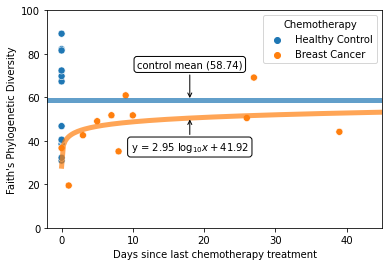

In [12]:
x = np.arange(0,45,0.25)+0.01
logy = fit[0] * np.log(x) + fit[1]


ax = sns.scatterplot(y="faith_pd",
                     x="Time difference",
                     data=time_faith,
                     hue="Chemotherapy",
                     x_jitter=True,
                     s=50)

ax.axhline(time_faith.loc[time_faith["Chemotherapy"]=="Healthy Control","faith_pd"].mean(),
           c="tab:blue",
           lw=5,
           alpha=0.7)

ax.plot(x,logy, lw=5, alpha=0.7, c="tab:orange")



annot_coords = (18, fit[0] * np.log(20) + fit[1])

ax.annotate("y = " + str(round(fit[0],2)) + r" $\log{_{10}}{x} + $" + str(round(fit[1], 2)), 
            xy=annot_coords, xytext=(18, fit[0] * np.log(20) + fit[1]-15),
            ha="center", bbox=dict(boxstyle="round", fc="w"),
            arrowprops=dict(arrowstyle="->"))

grp2_mean = time_faith.loc[time_faith["Chemotherapy"]=="Healthy Control","faith_pd"].mean()

ax.annotate("control mean (" + str(round(grp2_mean,2)) + ")", 
            xy=(18, grp2_mean), 
            xytext=(18, grp2_mean + 15),
            ha="center", bbox=dict(boxstyle="round", fc="w"),
            arrowprops=dict(arrowstyle="->"))

ax.set_ylim(0,100)
ax.set_xlim(-2,45)
ax.set_ylabel("Faith's Phylogenetic Diversity")
ax.set_xlabel("Days since last chemotherapy treatment")

plt.savefig("Figures/faith_log_fit_annotated.pdf")
plt.show()

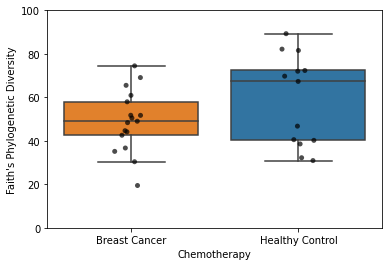

In [13]:
ax = sns.boxplot(x=metadata["Chemotherapy"],
                 y=faith,
                 showfliers=False,
                 palette=["tab:orange", "tab:blue"])

sns.stripplot(x=metadata["Chemotherapy"],
              y=faith,
              palette=["black"]*2,
              alpha=0.7)

ax.set_ylim(0,100)
ax.set_ylabel("Faith's Phylogenetic Diversity")

plt.savefig("Figures/faith_chemo.pdf")
plt.show()

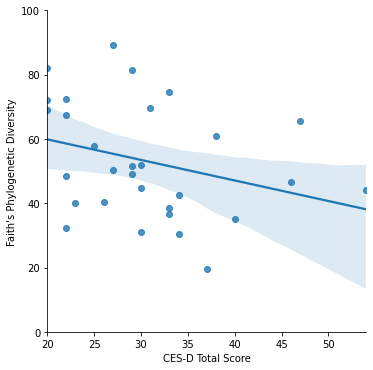

In [14]:
g = sns.lmplot(x="cesd_total",
                y="faith_pd",
                data=pd.concat([faith, metadata["cesd_total"]],
                              axis=1))

g.axes[0,0].set_ylim(0,100)
g.axes[0,0].set_ylabel("Faith's Phylogenetic Diversity")

g.axes[0,0].set_xlabel("CES-D Total Score")

plt.savefig("Figures/faith_cesd_corr.pdf")
plt.show()

### Beta Diversity

In [15]:
from skbio.stats.distance import mantel, permanova, DistanceMatrix
from scipy.spatial.distance import pdist, cdist

In [16]:
wuni = Artifact.load("core-diversity-results/weighted_unifrac_distance_matrix.qza").view(DistanceMatrix)
uuni = Artifact.load("core-diversity-results/unweighted_unifrac_distance_matrix.qza").view(DistanceMatrix)

In [17]:
metadata_beta = metadata
metadata_beta.index = metadata_beta.index.astype(str)
metadata_beta = metadata_beta.loc[list(wuni.ids)]

### PERMANOVA
#### Weighted UniFrac

In [18]:
for var in ["Chemotherapy", 
            "fact_c_r_imp_total_categorical",
            "stress_scale_total_categorical", 
            "cesd_total_categorical",
            "promis_tscore_categorical"]:
    perm = permanova(wuni, 
                    metadata_beta,
                    column=var)
    
    print("\n" + var)
    if perm[5] <= 0.05:
        print(" SIGNIFICANT")
    print(perm)


Chemotherapy
method name               PERMANOVA
test statistic name        pseudo-F
sample size                      30
number of groups                  2
test statistic             0.816605
p-value                       0.544
number of permutations          999
Name: PERMANOVA results, dtype: object

fact_c_r_imp_total_categorical
method name               PERMANOVA
test statistic name        pseudo-F
sample size                      30
number of groups                  2
test statistic              1.12314
p-value                       0.283
number of permutations          999
Name: PERMANOVA results, dtype: object

stress_scale_total_categorical
method name               PERMANOVA
test statistic name        pseudo-F
sample size                      30
number of groups                  2
test statistic             0.396761
p-value                       0.969
number of permutations          999
Name: PERMANOVA results, dtype: object

cesd_total_categorical
method name              

#### Unweighted UniFrac

In [19]:
for var in ["Chemotherapy", 
            "fact_c_r_imp_total_categorical",
            "stress_scale_total_categorical", 
            "cesd_total_categorical",
            "promis_tscore_categorical"]:
    perm = permanova(uuni, 
                    metadata_beta,
                    column=var)
    
    print("\n" + var)
    if perm[5] <= 0.05:
        print("**SIGNIFICANT**")
    print(perm)


Chemotherapy
method name               PERMANOVA
test statistic name        pseudo-F
sample size                      30
number of groups                  2
test statistic              1.07811
p-value                       0.231
number of permutations          999
Name: PERMANOVA results, dtype: object

fact_c_r_imp_total_categorical
**SIGNIFICANT**
method name               PERMANOVA
test statistic name        pseudo-F
sample size                      30
number of groups                  2
test statistic              1.51465
p-value                       0.014
number of permutations          999
Name: PERMANOVA results, dtype: object

stress_scale_total_categorical
method name               PERMANOVA
test statistic name        pseudo-F
sample size                      30
number of groups                  2
test statistic              0.80454
p-value                       0.915
number of permutations          999
Name: PERMANOVA results, dtype: object

cesd_total_categorical
method na

### Mantel
#### weighted UniFrac

In [20]:
for var in ["Time difference",
            "fact_c_total",
            "cesd_total",
            "promis_rawscore",
            "stress_scale_total"]:
    
    #initialize empty distance matrix
    dat = metadata_beta[var].dropna()
    dim = dat.shape[0]
    distm = np.empty((dim, dim))
    
    #fill distance matrix
    for i in range(dim):
        for j in range(dim):
            distm[i,j] = np.abs(dat.iloc[i]-dat.iloc[j])

    distm = DistanceMatrix(distm, ids=dat.index)

    #filter where we don't have data
    var_wuni = DistanceMatrix(wuni.to_data_frame().loc[dat.index,dat.index], 
                              ids=dat.index)
    #do the mantel
    man = mantel(var_wuni, 
                distm,
                method="spearman")

    print("\nvariable: ", var)
    print("significant: ", man[1]<0.05)
    print("corr coef: ", man[0])
    print("p value: ", man[1])


variable:  Time difference
significant:  False
corr coef:  0.15358421848850945
p value:  0.429

variable:  fact_c_total
significant:  False
corr coef:  0.002951707445232093
p value:  0.966

variable:  cesd_total
significant:  False
corr coef:  0.06348284364350958
p value:  0.435

variable:  promis_rawscore
significant:  False
corr coef:  -0.09411761358093827
p value:  0.275

variable:  stress_scale_total
significant:  False
corr coef:  -0.07729954779591705
p value:  0.2


#### Unweighted UniFrac

In [21]:
for var in ["Time difference",
            "fact_c_total",
            "cesd_total",
            "promis_rawscore",
            "stress_scale_total"]:
    
    #initialize empty distance matrix
    dat = metadata_beta[var].dropna()
    dim = dat.shape[0]
    distm = np.empty((dim, dim))
    
    #fill distance matrix
    for i in range(dim):
        for j in range(dim):
            distm[i,j] = np.abs(dat.iloc[i]-dat.iloc[j])

    distm = DistanceMatrix(distm, ids=dat.index)

    #filter where we don't have data
    var_uuni = DistanceMatrix(uuni.to_data_frame().loc[dat.index,dat.index], 
                              ids=dat.index)
    #do the mantel
    man = mantel(var_uuni, 
                distm,
                method="spearman")

    print("\nvariable: ", var)
    print("significant: ", man[1]<0.05)
    print("corr coef: ", man[0])
    print("p value: ", man[1])


variable:  Time difference
significant:  False
corr coef:  0.07642638277486448
p value:  0.682

variable:  fact_c_total
significant:  False
corr coef:  0.10572806820942689
p value:  0.155

variable:  cesd_total
significant:  False
corr coef:  0.0008239026282835701
p value:  0.99

variable:  promis_rawscore
significant:  False
corr coef:  0.01658151414238586
p value:  0.87

variable:  stress_scale_total
significant:  False
corr coef:  -0.03324645393547799
p value:  0.607


## Differential abundance

! qiime taxa collapse \
--i-table nobloom_table.qza \
--i-taxonomy taxonomy-gg.qza \
--p-level 2 \
--o-collapsed-table L2-nobloom-table.qza

! qiime taxa collapse \
--i-table nobloom_table.qza \
--i-taxonomy taxonomy-gg.qza \
--p-level 6 \
--o-collapsed-table L6-nobloom-table.qza

! qiime composition add-pseudocount \
--i-table L2-nobloom-table.qza \
--o-composition-table L2-nobloom-pseudo-table.qza

! qiime composition add-pseudocount \
--i-table L6-nobloom-table.qza \
--o-composition-table L6-nobloom-pseudo-table.qza

! qiime composition ancom \
--i-table L2-nobloom-pseudo-table.qza \
--m-metadata-file nobloom_metadata.tsv \
--m-metadata-column "Chemotherapy" \
--o-visualization ANCOM-L2-chemo.qzv

! qiime composition ancom \
--i-table L6-nobloom-pseudo-table.qza \
--m-metadata-file nobloom_metadata.tsv \
--m-metadata-column "Chemotherapy" \
--o-visualization ANCOM-L6-chemo.qzv

#### NO SIGNIFICANT RESULTS FROM ANCOM

### Taxa correlations

In [22]:
L2 = Artifact.load("L2-nobloom-table.qza").view(pd.DataFrame)

L2mat = np.matrix(L2)
L2mat /= L2mat.sum(axis=1)

L2 = pd.DataFrame(L2mat,
                  columns=L2.columns,
                  index=L2.index)

In [59]:
print("SPEARMAN CORR PHYLA AND FACT COG")
for col in L2.columns:
    spear = spearmanr(metadata["fact_c_total"],
                      L2[col])
    
    if spear.pvalue < 0.05:
        print("SIGNIFICANT:")
    print(col, spear)

SPEARMAN CORR PHYLA AND FACT COG
k__Archaea;p__Euryarchaeota SpearmanrResult(correlation=0.053398285092415676, pvalue=0.7716208536223468)
k__Bacteria;__ SpearmanrResult(correlation=0.00495347671714674, pvalue=0.9785344195744046)
k__Bacteria;p__ SpearmanrResult(correlation=0.29795093816833756, pvalue=0.09766741711407034)
k__Bacteria;p__Actinobacteria SpearmanrResult(correlation=-0.06729006686386008, pvalue=0.714424189864929)
k__Bacteria;p__Bacteroidetes SpearmanrResult(correlation=-0.007334067233118264, pvalue=0.9682226176176119)
k__Bacteria;p__Cyanobacteria SpearmanrResult(correlation=0.26400645206450624, pvalue=0.14426886968436842)
k__Bacteria;p__Firmicutes SpearmanrResult(correlation=-0.015768244551204267, pvalue=0.9317406945378783)
k__Bacteria;p__Fusobacteria SpearmanrResult(correlation=0.04412469905425526, pvalue=0.8104909085348513)
k__Bacteria;p__Lentisphaerae SpearmanrResult(correlation=0.18812509191329121, pvalue=0.30249438587549515)
k__Bacteria;p__Proteobacteria SpearmanrResult

In [60]:
print("SPEARMAN CORR PHYLA AND CESD")
for col in L2.columns:
    spear = spearmanr(metadata["cesd_total"],
                      L2[col])
    
    if spear.pvalue < 0.05:
        print("SIGNIFICANT:")
    print(col, spear)

SPEARMAN CORR PHYLA AND CESD
k__Archaea;p__Euryarchaeota SpearmanrResult(correlation=0.084683657215937, pvalue=0.6449326081059528)
k__Bacteria;__ SpearmanrResult(correlation=-0.0011144606409142685, pvalue=0.9951700297526646)
k__Bacteria;p__ SpearmanrResult(correlation=-0.34523918629487627, pvalue=0.052960824597309546)
k__Bacteria;p__Actinobacteria SpearmanrResult(correlation=0.20746117897552022, pvalue=0.25456332467528636)
k__Bacteria;p__Bacteroidetes SpearmanrResult(correlation=-0.23906731075921328, pvalue=0.18758149716241473)
k__Bacteria;p__Cyanobacteria SpearmanrResult(correlation=-0.046801288547089225, pvalue=0.7992220311766998)
k__Bacteria;p__Firmicutes SpearmanrResult(correlation=0.22914445543177478, pvalue=0.20711777697940975)
k__Bacteria;p__Fusobacteria SpearmanrResult(correlation=-0.0162001900988084, pvalue=0.929875356679561)
k__Bacteria;p__Lentisphaerae SpearmanrResult(correlation=-0.22668457080156565, pvalue=0.21216982708849547)
k__Bacteria;p__Proteobacteria SpearmanrResult(

UNTRANSFORMED HISTOGRAMS


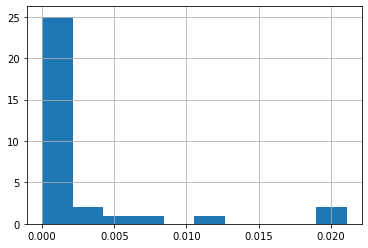

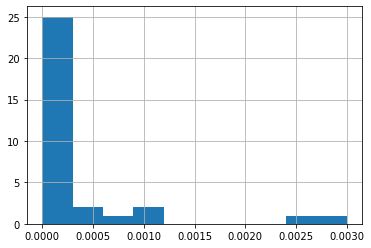

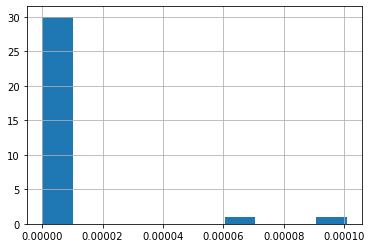

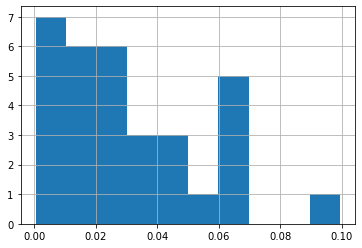

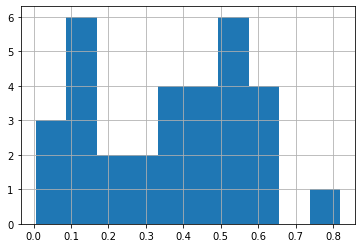

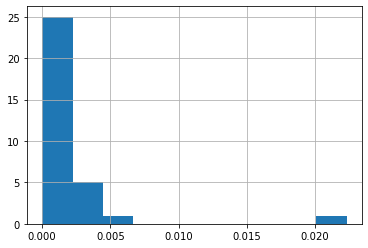

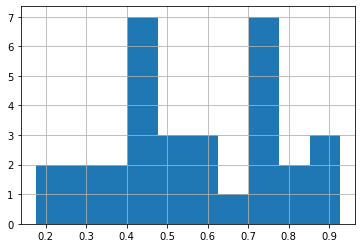

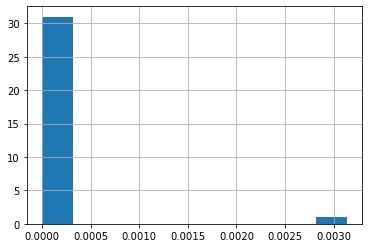

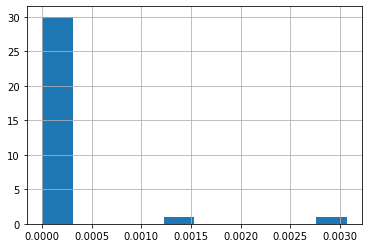

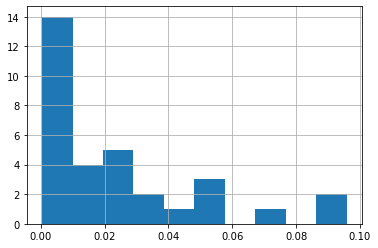

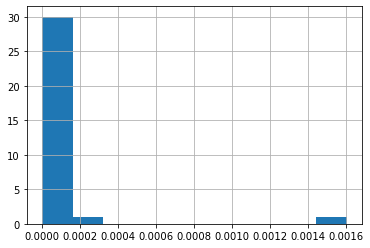

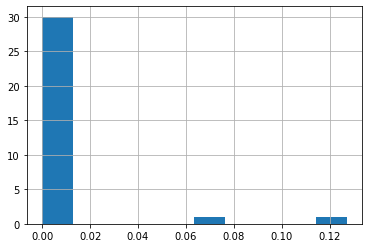

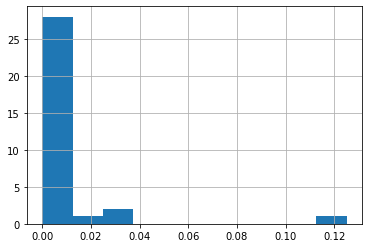

In [61]:
print("UNTRANSFORMED HISTOGRAMS")
for col in L2.columns:
    L2[col].hist()
    plt.show()

In [25]:
from skbio.stats.composition import clr

In [39]:
print("PEARSON CORR PHYLA AND FACT-COG")
for col in L2.columns:
    r, p = pearsonr(metadata["fact_c_total"],
                      clr(L2[col].apply(lambda x: x+0.00001)))
    
    if p < 0.05:
        print("SIGNIFICANT:")
    print(col, r, p)

PEARSON CORR PHYLA AND FACT-COG
k__Archaea;p__Euryarchaeota 0.07665215188261981 0.6766982293826271
k__Bacteria;__ 0.016686850208478494 0.9277741748079694
k__Bacteria;p__ 0.25059334669006755 0.16655460419298518
k__Bacteria;p__Actinobacteria -0.02302767519780463 0.9004460455923246
k__Bacteria;p__Bacteroidetes -0.12772777454441553 0.48602045790054943
k__Bacteria;p__Cyanobacteria 0.2766904446064558 0.12526825115094287
k__Bacteria;p__Firmicutes 0.1100065101366609 0.548935504799943
k__Bacteria;p__Fusobacteria -0.07837791727515811 0.6698240698157426
k__Bacteria;p__Lentisphaerae 0.1253846094084028 0.4941209819292371
k__Bacteria;p__Proteobacteria -0.005937774017303887 0.9742703161175928
k__Bacteria;p__Synergistetes -0.2654222675007799 0.14204980784054042
k__Bacteria;p__Tenericutes 0.15199020469213326 0.40630159652397085
k__Bacteria;p__Verrucomicrobia 0.0032298423488376846 0.9860027596500022


In [40]:
print("PEARSON CORR PHYLA AND CESD")
for col in L2.columns:
    r, p = pearsonr(metadata["cesd_total"],
                      clr(L2[col].apply(lambda x: x+0.00001)))
    
    if p < 0.05:
        print("SIGNIFICANT:")
    print(col, r, p)

PEARSON CORR PHYLA AND CESD
k__Archaea;p__Euryarchaeota -0.004932870525326996 0.9786236948924716
k__Bacteria;__ 0.006715796649576916 0.970900309293152
k__Bacteria;p__ -0.2932205912055708 0.10336792843765631
k__Bacteria;p__Actinobacteria 0.19731258390636944 0.2790542624137768
k__Bacteria;p__Bacteroidetes -0.1257670293337986 0.49279426126629244
k__Bacteria;p__Cyanobacteria -0.036563539608624705 0.8425195477753593
k__Bacteria;p__Firmicutes 0.05921707065733535 0.7475001030302989
k__Bacteria;p__Fusobacteria 0.10930519774488566 0.5515014099856227
k__Bacteria;p__Lentisphaerae -0.19567065570684689 0.2831547685562246
k__Bacteria;p__Proteobacteria 0.01963358741243236 0.9150621783109515
k__Bacteria;p__Synergistetes -0.02791891047679504 0.8794400986945778
k__Bacteria;p__Tenericutes 0.1186288154613791 0.5178542470783736
k__Bacteria;p__Verrucomicrobia -0.02998512188017926 0.8705898339799109


CLR TRANSFORMED HISTOGRAMS
k__Archaea;p__Euryarchaeota


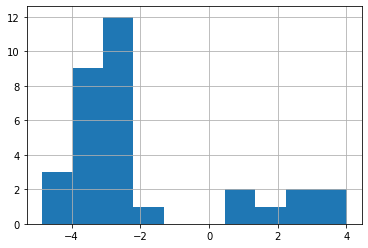

k__Bacteria;__


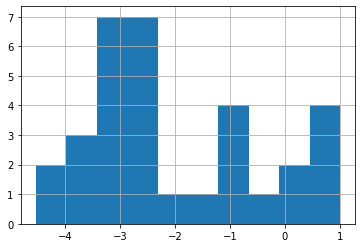

k__Bacteria;p__


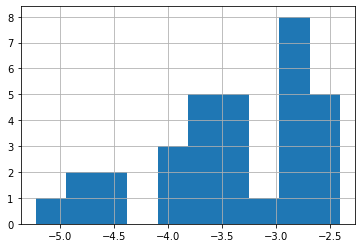

k__Bacteria;p__Actinobacteria


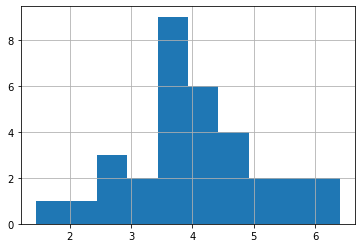

k__Bacteria;p__Bacteroidetes


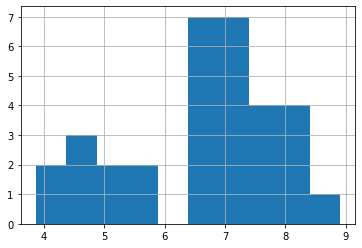

k__Bacteria;p__Cyanobacteria


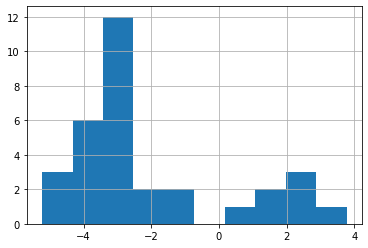

k__Bacteria;p__Firmicutes


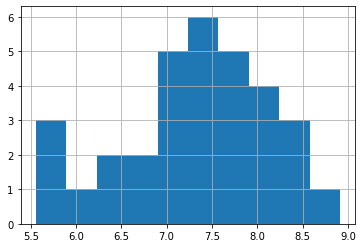

k__Bacteria;p__Fusobacteria


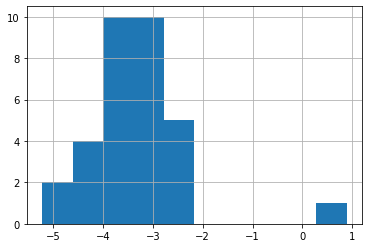

k__Bacteria;p__Lentisphaerae


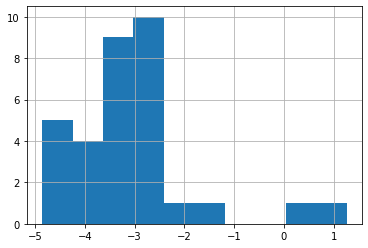

k__Bacteria;p__Proteobacteria


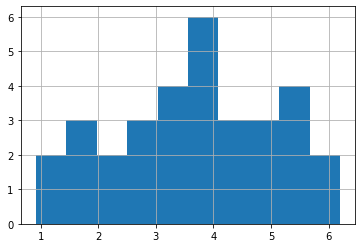

k__Bacteria;p__Synergistetes


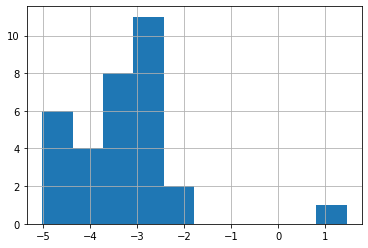

k__Bacteria;p__Tenericutes


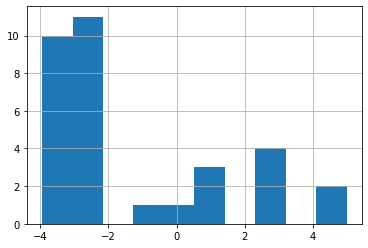

k__Bacteria;p__Verrucomicrobia


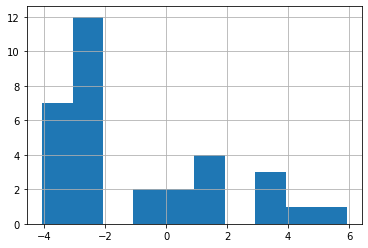

In [63]:
clr_L2 = pd.DataFrame(clr(L2.apply(lambda x: x+0.00001)),
                     index=L2.index,
                     columns=L2.columns)

clr_L2["participant ID"] = metadata["plate.sample.id"].apply(lambda x: x.split("-")[0])
clr_L2 = clr_L2.reset_index().set_index("participant ID")
clr_L2 = clr_L2.rename(columns={"index":"SampleID"})

clr_L2.to_csv("clr_transformed_phyla.csv")

print("CLR TRANSFORMED HISTOGRAMS")
for col in clr_L2.drop("SampleID",axis=1):
    print(col)
    clr_L2[col].hist()
    plt.show()

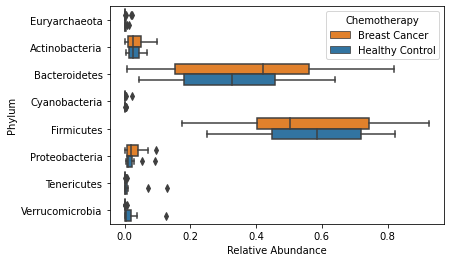

In [54]:
L2chemo = pd.concat([L2.loc[:,L2.mean(axis=0)>0.001], 
                     metadata["Chemotherapy"]],
                    axis=1)

L2chemo = pd.melt(L2chemo, id_vars="Chemotherapy")

L2chemo["Phylum"] = L2chemo["variable"].apply(lambda x: x.split("p__")[1])

ax = sns.boxplot(x="value",
                y="Phylum",
                hue="Chemotherapy",
                data=L2chemo,
                palette=["tab:orange","tab:blue"])

ax.set_xlabel("Relative Abundance")

plt.savefig("Figures/Phyla-boxplots.pdf")
plt.show()

### Akkermansia

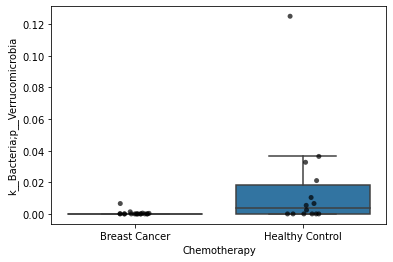

In [304]:
ax = sns.boxplot(x=metadata["Chemotherapy"],
                y=L2["k__Bacteria;p__Verrucomicrobia"],
                showfliers=False,
                 palette=["tab:orange", "tab:blue"])

sns.stripplot(x=metadata["Chemotherapy"],
              y=L2["k__Bacteria;p__Verrucomicrobia"],
              palette=["black"]*2,
              alpha=0.7,
              ax=ax)
plt.show()

In [305]:
kruskal(L2.loc[metadata["Chemotherapy"]=="Breast Cancer","k__Bacteria;p__Verrucomicrobia"],
        L2.loc[metadata["Chemotherapy"]=="Healthy Control","k__Bacteria;p__Verrucomicrobia"])

KruskalResult(statistic=5.518042867440461, pvalue=0.01882130426578598)

In [306]:
L6 = Artifact.load("L6-nobloom-table.qza").view(pd.DataFrame)

L6mat = np.matrix(L6)
L6mat /= L6mat.sum(axis=1)

L6 = pd.DataFrame(L6mat,
                  columns=L6.columns,
                  index=L6.index)

In [307]:
list(filter(lambda x: "akkermansia" in x.lower(), L6.columns))

['k__Bacteria;p__Verrucomicrobia;c__Verrucomicrobiae;o__Verrucomicrobiales;f__Verrucomicrobiaceae;g__Akkermansia']

In [308]:
akker = 'k__Bacteria;p__Verrucomicrobia;c__Verrucomicrobiae;o__Verrucomicrobiales;f__Verrucomicrobiaceae;g__Akkermansia'

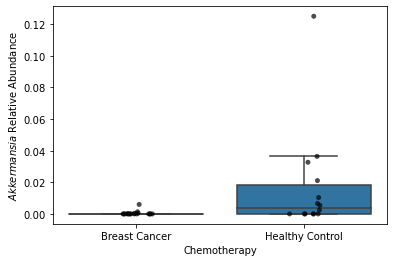

In [312]:
ax = sns.boxplot(x=metadata["Chemotherapy"],
                y=L6[akker],
                showfliers=False,
                palette=["tab:orange", "tab:blue"])

sns.stripplot(x=metadata["Chemotherapy"],
              y=L6[akker],
              palette=["black"]*2,
              alpha=0.7,
              ax=ax)

ax.set_ylabel(r"$Akkermansia$ Relative Abundance")

plt.savefig("Figures/Akkermansia-boxplot.pdf")
plt.show()

In [311]:
kruskal(L6.loc[metadata["Chemotherapy"]=="Breast Cancer",akker],
        L6.loc[metadata["Chemotherapy"]=="Healthy Control",akker])

KruskalResult(statistic=5.518042867440461, pvalue=0.01882130426578598)